In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models, Sequential, backend, callbacks

try:
    from scikeras.wrappers import KerasClassifier, KerasRegressor
except ImportError:
    !python -m pip install scikeras
    from scikeras.wrappers import KerasClassifier, KerasRegressor
  
import cv2
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(linewidth=100000, precision=3)
import sys
import pandas as pd

from skimage import data, io, filters
from skimage.transform import resize
from skimage.transform import rotate

from sklearn.model_selection import GridSearchCV, KFold
import datetime
from tqdm.keras import TqdmCallback

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
tf.config.set_visible_devices(gpus[0:2], 'GPU')
logical_devices = tf.config.list_logical_devices('GPU')
print(logical_devices)
    
(img_train, label_train), (img_test, label_test) = tfds.as_numpy(tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    batch_size=-1,
    as_supervised=True,
))

2022-03-19 04:22:57.647353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 04:22:57.647969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 04:22:57.648493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 04:22:57.649000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 04:22:57.794697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

Num GPUs Available:  4
[LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]


2022-03-19 04:22:57.802111: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-19 04:22:57.990488: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 04:22:57.990687: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 04:22:57.990843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

#Using a NNet for classification

### Prelude
- The data is in the form of a 28x28 matrix that contains the greyscale pixel of an object. To use it for a Neural network, we will apply convolution to it  and then pool it into a smaller matrix as the data procesing step i.e. we will use a CNN. In addition to that, we normalize the image's pixel values to be a number between 0 and 1 by dividing by 255

In [3]:
img_train = img_train / 255
img_test = img_test / 255

#### CNN with Maxpooling

In [4]:
%%script false --no-raise-error
model = models.Sequential() # Create the model
model.add(layers.Conv2D(28, (3, 3), activation='relu', input_shape=(28, 28 , 1))) # add the first layer to convole the input matrix using a 3x3 kernal with a relu activation to prevent linearity
model.add(layers.MaxPooling2D(pool_size = (2, 2))) #pool to decrease dimension of image
model.add(layers.Conv2D(56, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size = (2, 2))) #pool
model.add(layers.Conv2D(112, (3, 3), activation='relu'))


model.add(layers.Flatten())
model.add(layers.Dense(112, activation='relu'))
model.add(layers.Dense(10))

In [5]:
%%script false --no-raise-error
model.summary()

In [6]:
%%script false --no-raise-error
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(img_train, label_train, epochs=10, 
                    validation_data=(img_test, label_test))

In [7]:
%%script false --no-raise-error
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(img_test,  label_test, verbose=2)

#### CNN with avgerage pooling

In [8]:
%%script false --no-raise-error
model = models.Sequential() # Create the model
model.add(layers.Conv2D(28, (3, 3), activation='relu', input_shape=(28, 28 , 1))) # add the first layer to convole the input matrix using a 3x3 kernal with a relu activation to prevent linearity
model.add(layers.AveragePooling2D(pool_size = (2, 2))) #pool to decrease dimension of image
model.add(layers.Conv2D(56, (3, 3), activation='relu'))
model.add(layers.AveragePooling2D(pool_size = (2, 2))) #pool
model.add(layers.Conv2D(112, (3, 3), activation='relu'))


model.add(layers.Flatten())
model.add(layers.Dense(112, activation='relu'))
model.add(layers.Dense(10))

In [9]:
%%script false --no-raise-error
model.summary()

In [10]:
%%script false --no-raise-error
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(img_train, label_train, epochs=10, 
                    validation_data=(img_test, label_test))

In [11]:
%%script false --no-raise-error
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(img_test,  label_test, verbose=2)
backend.clear_session()

### Data Augmentation

In [12]:
augmented_data = []
augmented_data_ys = []
for i,img in enumerate(img_train):
    #rotate 90 degrees
    #augmented_data.append(rotate(img,90))
    #augmented_data_ys.append(label_train[i])

    #rotate 180 degrees
    #augmented_data.append(rotate(img,180))
    #augmented_data_ys.append(label_train[i])

    #rotate 270 degrees
    #augmented_data.append(rotate(img,270))
    #augmented_data_ys.append(label_train[i])

    #flip left to right
    augmented_data.append(np.fliplr(img))
    augmented_data_ys.append(label_train[i])

In [13]:
augmented_data = np.array(augmented_data)
augmented_data_ys = np.array(augmented_data_ys)
img_train = np.concatenate((img_train,augmented_data))
print(img_train.shape)
label_train = np.concatenate((label_train,augmented_data_ys))
print(label_train.shape)

(120000, 28, 28, 1)
(120000,)


### CNN with augmented data and GridSearchCV

Currently on filter  1, layer 0, node 100
Fold 1/3, params filters = 1, layers = 0, nodes = 100


2022-03-19 04:23:03.757021: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-03-19 04:23:05.923079: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-19 04:23:06.047890: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Fold 2/3, params filters = 1, layers = 0, nodes = 100
Fold 3/3, params filters = 1, layers = 0, nodes = 100
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4732)              0         
                                                                 
 dense (Dense)               (None, 10)                47330     
                                                                 
Total params: 47,610
Trainable params: 47,610
Non-trainable params: 0
_________________________________________________________________


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.3048 - accuracy: 0.9073 - 282ms/epoch - 901us/step
Mean CV score + stddev: 0.9091833432515463 +/- 7.72736973693887e-05
Accuracy on test set: 0.9072999954223633


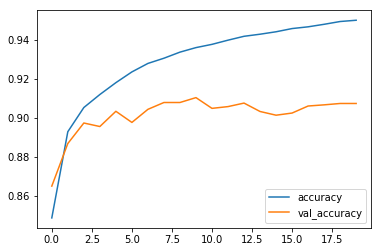

Currently on filter  1, layer 1, node 100
Fold 1/3, params filters = 1, layers = 1, nodes = 100
Fold 2/3, params filters = 1, layers = 1, nodes = 100
Fold 3/3, params filters = 1, layers = 1, nodes = 100
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4732)              0         
                                                                 
 dense (Dense)               (None, 100)               473300    
                                                                 
 dense_1 (Dense)             (None, 10)           

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.6252 - accuracy: 0.9075 - 296ms/epoch - 947us/step
Mean CV score + stddev: 0.9214333295822144 +/- 0.003741468217346663
Accuracy on test set: 0.9075000286102295


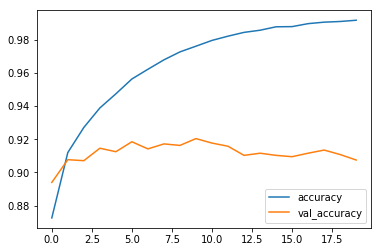

Currently on filter  1, layer 1, node 250
Fold 1/3, params filters = 1, layers = 1, nodes = 250
Fold 2/3, params filters = 1, layers = 1, nodes = 250
Fold 3/3, params filters = 1, layers = 1, nodes = 250
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4732)              0         
                                                                 
 dense (Dense)               (None, 250)               1183250   
                                                                 
 dense_1 (Dense)             (None, 10)           

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.7363 - accuracy: 0.9101 - 294ms/epoch - 938us/step
Mean CV score + stddev: 0.924999992052714 +/- 0.0034507735919781382
Accuracy on test set: 0.910099983215332


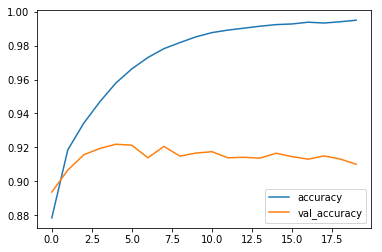

Currently on filter  1, layer 1, node 500
Fold 1/3, params filters = 1, layers = 1, nodes = 500
Fold 2/3, params filters = 1, layers = 1, nodes = 500
Fold 3/3, params filters = 1, layers = 1, nodes = 500
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4732)              0         
                                                                 
 dense (Dense)               (None, 500)               2366500   
                                                                 
 dense_1 (Dense)             (None, 10)           

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.7207 - accuracy: 0.9191 - 284ms/epoch - 906us/step
Mean CV score + stddev: 0.9305750131607056 +/- 0.001978945804429599
Accuracy on test set: 0.9190999865531921


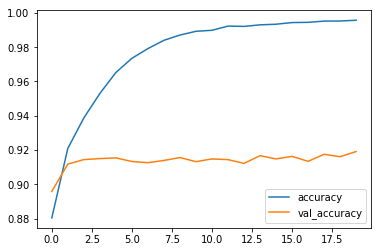

Currently on filter  1, layer 1, node 1000
Fold 1/3, params filters = 1, layers = 1, nodes = 1000
Fold 2/3, params filters = 1, layers = 1, nodes = 1000
Fold 3/3, params filters = 1, layers = 1, nodes = 1000
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4732)              0         
                                                                 
 dense (Dense)               (None, 1000)              4733000   
                                                                 
 dense_1 (Dense)             (None, 10)       

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.8061 - accuracy: 0.9106 - 297ms/epoch - 949us/step
Mean CV score + stddev: 0.9318333268165588 +/- 0.0011944809310071231
Accuracy on test set: 0.9106000065803528


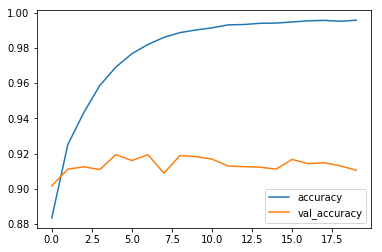

Currently on filter  1, layer 2, node 100
Fold 1/3, params filters = 1, layers = 2, nodes = 100
Fold 2/3, params filters = 1, layers = 2, nodes = 100
Fold 3/3, params filters = 1, layers = 2, nodes = 100
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4732)              0         
                                                                 
 dense (Dense)               (None, 100)               473300    
                                                                 
 dense_1 (Dense)             (None, 100)          

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.5999 - accuracy: 0.9106 - 292ms/epoch - 934us/step
Mean CV score + stddev: 0.9240833520889282 +/- 0.0005720270294460452
Accuracy on test set: 0.9106000065803528


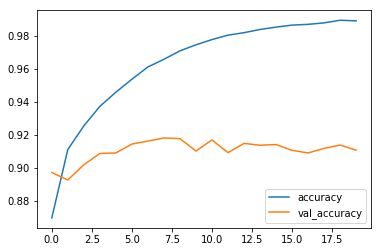

Currently on filter  1, layer 2, node 250
Fold 1/3, params filters = 1, layers = 2, nodes = 250
Fold 2/3, params filters = 1, layers = 2, nodes = 250
Fold 3/3, params filters = 1, layers = 2, nodes = 250
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4732)              0         
                                                                 
 dense (Dense)               (None, 250)               1183250   
                                                                 
 dense_1 (Dense)             (None, 250)          

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.7665 - accuracy: 0.9150 - 304ms/epoch - 970us/step
Mean CV score + stddev: 0.9261916677157084 +/- 0.002553926900110265
Accuracy on test set: 0.9150000214576721


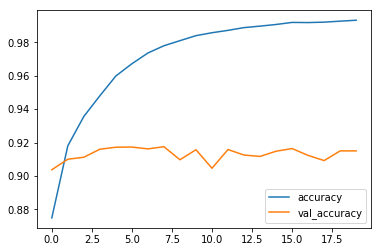

Currently on filter  1, layer 2, node 500
Fold 1/3, params filters = 1, layers = 2, nodes = 500
Fold 2/3, params filters = 1, layers = 2, nodes = 500
Fold 3/3, params filters = 1, layers = 2, nodes = 500
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4732)              0         
                                                                 
 dense (Dense)               (None, 500)               2366500   
                                                                 
 dense_1 (Dense)             (None, 500)          

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.8179 - accuracy: 0.9114 - 312ms/epoch - 996us/step
Mean CV score + stddev: 0.9291999936103821 +/- 0.0036878897134837263
Accuracy on test set: 0.9114000201225281


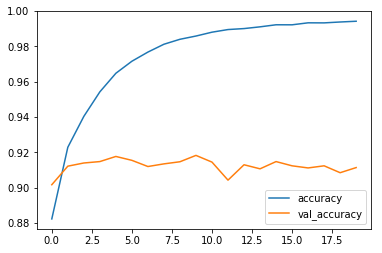

Currently on filter  1, layer 2, node 1000
Fold 1/3, params filters = 1, layers = 2, nodes = 1000
Fold 2/3, params filters = 1, layers = 2, nodes = 1000
Fold 3/3, params filters = 1, layers = 2, nodes = 1000
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4732)              0         
                                                                 
 dense (Dense)               (None, 1000)              4733000   
                                                                 
 dense_1 (Dense)             (None, 1000)     

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.8532 - accuracy: 0.9121 - 305ms/epoch - 973us/step
Mean CV score + stddev: 0.9289249976476034 +/- 0.0011575921293357106
Accuracy on test set: 0.9121000170707703


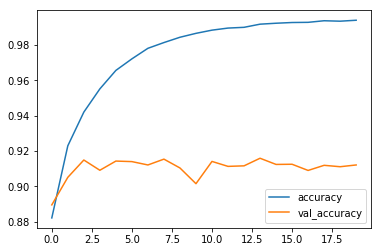

Currently on filter  2, layer 0, node 100
Fold 1/3, params filters = 2, layers = 0, nodes = 100
Fold 2/3, params filters = 2, layers = 0, nodes = 100
Fold 3/3, params filters = 2, layers = 0, nodes = 100
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 56)        14168     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 56)         0         
 2D)                                                             
                                                  

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.3124 - accuracy: 0.9044 - 295ms/epoch - 943us/step
Mean CV score + stddev: 0.9113666613896688 +/- 0.002247255345708684
Accuracy on test set: 0.9043999910354614


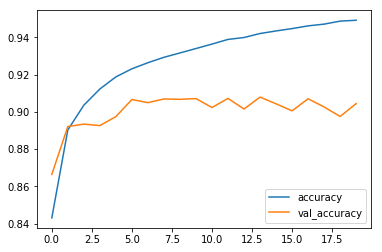

Currently on filter  2, layer 1, node 100
Fold 1/3, params filters = 2, layers = 1, nodes = 100
Fold 2/3, params filters = 2, layers = 1, nodes = 100
Fold 3/3, params filters = 2, layers = 1, nodes = 100
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 56)        14168     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 56)         0         
 2D)                                                             
                                                  

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.4981 - accuracy: 0.9123 - 338ms/epoch - 1ms/step
Mean CV score + stddev: 0.9192249774932861 +/- 0.0024016452120692194
Accuracy on test set: 0.9122999906539917


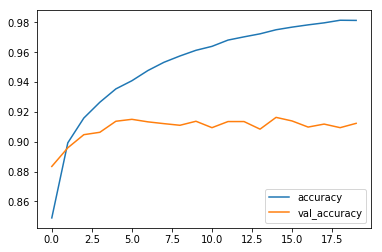

Currently on filter  2, layer 1, node 250
Fold 1/3, params filters = 2, layers = 1, nodes = 250
Fold 2/3, params filters = 2, layers = 1, nodes = 250
Fold 3/3, params filters = 2, layers = 1, nodes = 250
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 56)        14168     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 56)         0         
 2D)                                                             
                                                  

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.6186 - accuracy: 0.9134 - 345ms/epoch - 1ms/step
Mean CV score + stddev: 0.9251833359400431 +/- 0.0020371809567529334
Accuracy on test set: 0.9133999943733215


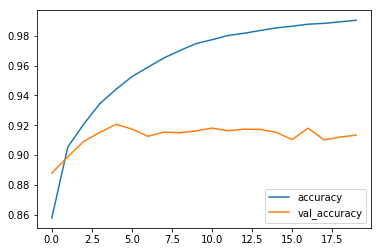

Currently on filter  2, layer 1, node 500
Fold 1/3, params filters = 2, layers = 1, nodes = 500
Fold 2/3, params filters = 2, layers = 1, nodes = 500
Fold 3/3, params filters = 2, layers = 1, nodes = 500
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 56)        14168     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 56)         0         
 2D)                                                             
                                                  

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.6287 - accuracy: 0.9072 - 343ms/epoch - 1ms/step
Mean CV score + stddev: 0.9263333280881246 +/- 0.0021284070255578507
Accuracy on test set: 0.9071999788284302


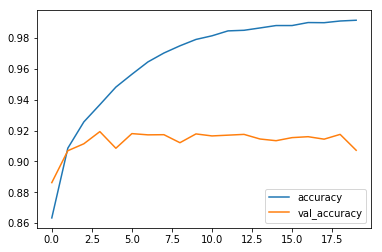

Currently on filter  2, layer 1, node 1000
Fold 1/3, params filters = 2, layers = 1, nodes = 1000
Fold 2/3, params filters = 2, layers = 1, nodes = 1000
Fold 3/3, params filters = 2, layers = 1, nodes = 1000
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 56)        14168     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 56)         0         
 2D)                                                             
                                              

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.6899 - accuracy: 0.9124 - 340ms/epoch - 1ms/step
Mean CV score + stddev: 0.925391674041748 +/- 0.00328888851832904
Accuracy on test set: 0.9124000072479248


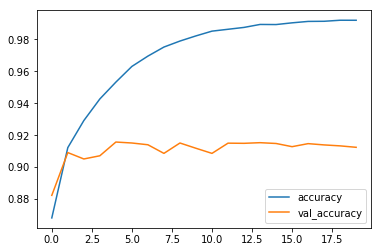

Currently on filter  2, layer 2, node 100
Fold 1/3, params filters = 2, layers = 2, nodes = 100
Fold 2/3, params filters = 2, layers = 2, nodes = 100
Fold 3/3, params filters = 2, layers = 2, nodes = 100
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 56)        14168     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 56)         0         
 2D)                                                             
                                                  

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.4788 - accuracy: 0.9167 - 351ms/epoch - 1ms/step
Mean CV score + stddev: 0.9214583436648051 +/- 0.0015548625389310373
Accuracy on test set: 0.916700005531311


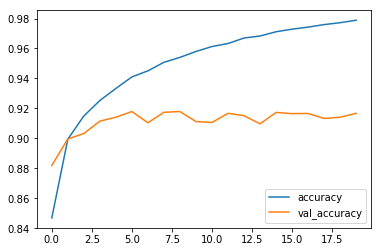

Currently on filter  2, layer 2, node 250
Fold 1/3, params filters = 2, layers = 2, nodes = 250
Fold 2/3, params filters = 2, layers = 2, nodes = 250
Fold 3/3, params filters = 2, layers = 2, nodes = 250
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 56)        14168     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 56)         0         
 2D)                                                             
                                                  

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.5781 - accuracy: 0.9140 - 355ms/epoch - 1ms/step
Mean CV score + stddev: 0.9246833324432373 +/- 0.0009958981779867025
Accuracy on test set: 0.9139999747276306


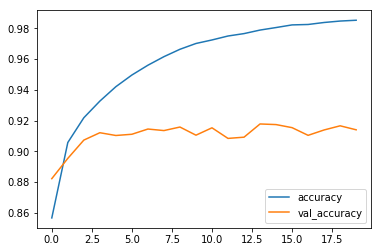

Currently on filter  2, layer 2, node 500
Fold 1/3, params filters = 2, layers = 2, nodes = 500
Fold 2/3, params filters = 2, layers = 2, nodes = 500
Fold 3/3, params filters = 2, layers = 2, nodes = 500
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 56)        14168     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 56)         0         
 2D)                                                             
                                                  

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.6410 - accuracy: 0.9118 - 376ms/epoch - 1ms/step
Mean CV score + stddev: 0.9233000079790751 +/- 0.0058781822341177755
Accuracy on test set: 0.9118000268936157


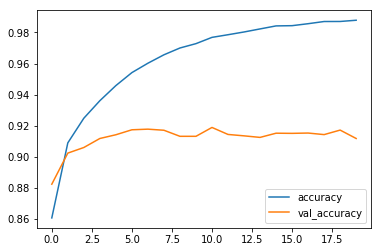

Currently on filter  2, layer 2, node 1000
Fold 1/3, params filters = 2, layers = 2, nodes = 1000
Fold 2/3, params filters = 2, layers = 2, nodes = 1000
Fold 3/3, params filters = 2, layers = 2, nodes = 1000
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 56)        14168     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 56)         0         
 2D)                                                             
                                              

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.6495 - accuracy: 0.9088 - 362ms/epoch - 1ms/step
Mean CV score + stddev: 0.924791673819224 +/- 0.0012145475662171587
Accuracy on test set: 0.9088000059127808


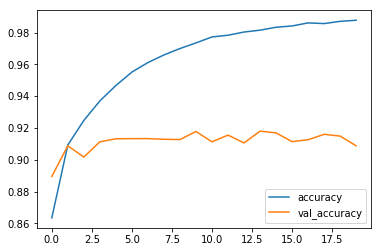

Currently on filter  3, layer 0, node 100
Fold 1/3, params filters = 3, layers = 0, nodes = 100
Fold 2/3, params filters = 3, layers = 0, nodes = 100
Fold 3/3, params filters = 3, layers = 0, nodes = 100
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 56)        14168     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 56)         0         
 2D)                                                             
                                                  

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.4272 - accuracy: 0.8983 - 372ms/epoch - 1ms/step
Mean CV score + stddev: 0.9014250040054321 +/- 0.003557104755096519
Accuracy on test set: 0.8982999920845032


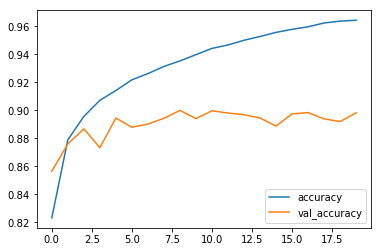

Currently on filter  3, layer 1, node 100
Fold 1/3, params filters = 3, layers = 1, nodes = 100
Fold 2/3, params filters = 3, layers = 1, nodes = 100
Fold 3/3, params filters = 3, layers = 1, nodes = 100
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 56)        14168     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 56)         0         
 2D)                                                             
                                                  

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.4490 - accuracy: 0.8957 - 376ms/epoch - 1ms/step
Mean CV score + stddev: 0.9028166731198629 +/- 0.003574070571436325
Accuracy on test set: 0.8956999778747559


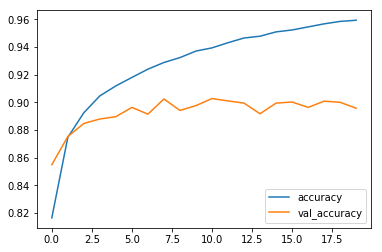

Currently on filter  3, layer 1, node 250
Fold 1/3, params filters = 3, layers = 1, nodes = 250
Fold 2/3, params filters = 3, layers = 1, nodes = 250
Fold 3/3, params filters = 3, layers = 1, nodes = 250
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 56)        14168     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 56)         0         
 2D)                                                             
                                                  

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.5363 - accuracy: 0.8912 - 386ms/epoch - 1ms/step
Mean CV score + stddev: 0.9053000013033549 +/- 0.001226940026116665
Accuracy on test set: 0.8912000060081482


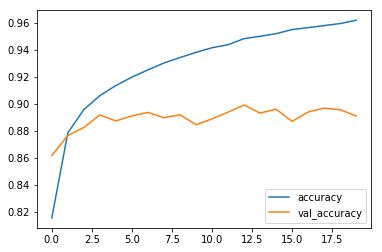

Currently on filter  3, layer 1, node 500
Fold 1/3, params filters = 3, layers = 1, nodes = 500
Fold 2/3, params filters = 3, layers = 1, nodes = 500
Fold 3/3, params filters = 3, layers = 1, nodes = 500
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 56)        14168     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 56)         0         
 2D)                                                             
                                                  

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.5296 - accuracy: 0.8978 - 396ms/epoch - 1ms/step
Mean CV score + stddev: 0.9020833174387614 +/- 0.0015974331954708633
Accuracy on test set: 0.8978000283241272


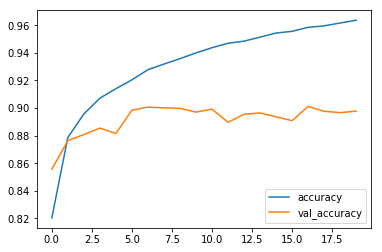

Currently on filter  3, layer 1, node 1000
Fold 1/3, params filters = 3, layers = 1, nodes = 1000
Fold 2/3, params filters = 3, layers = 1, nodes = 1000
Fold 3/3, params filters = 3, layers = 1, nodes = 1000
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 56)        14168     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 56)         0         
 2D)                                                             
                                              

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.5109 - accuracy: 0.8987 - 395ms/epoch - 1ms/step
Mean CV score + stddev: 0.9038083155949911 +/- 0.0010050534310458543
Accuracy on test set: 0.8986999988555908


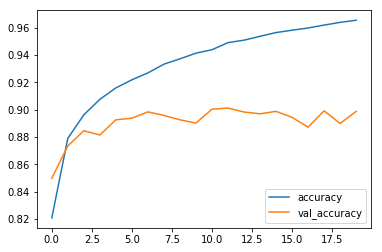

Currently on filter  3, layer 2, node 100
Fold 1/3, params filters = 3, layers = 2, nodes = 100
Fold 2/3, params filters = 3, layers = 2, nodes = 100
Fold 3/3, params filters = 3, layers = 2, nodes = 100
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 56)        14168     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 56)         0         
 2D)                                                             
                                                  

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.4043 - accuracy: 0.8979 - 406ms/epoch - 1ms/step
Mean CV score + stddev: 0.9036083420117696 +/- 0.004108356747783177
Accuracy on test set: 0.8978999853134155


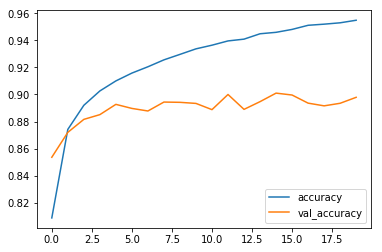

Currently on filter  3, layer 2, node 250
Fold 1/3, params filters = 3, layers = 2, nodes = 250
Fold 2/3, params filters = 3, layers = 2, nodes = 250
Fold 3/3, params filters = 3, layers = 2, nodes = 250
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 56)        14168     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 56)         0         
 2D)                                                             
                                                  

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.4340 - accuracy: 0.8925 - 376ms/epoch - 1ms/step
Mean CV score + stddev: 0.9012083212534586 +/- 0.003545035540500529
Accuracy on test set: 0.8924999833106995


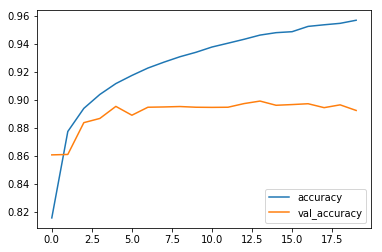

Currently on filter  3, layer 2, node 500
Fold 1/3, params filters = 3, layers = 2, nodes = 500
Fold 2/3, params filters = 3, layers = 2, nodes = 500
Fold 3/3, params filters = 3, layers = 2, nodes = 500
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 56)        14168     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 56)         0         
 2D)                                                             
                                                  

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.4727 - accuracy: 0.8897 - 402ms/epoch - 1ms/step
Mean CV score + stddev: 0.9041166504224142 +/- 0.0038055349095154657
Accuracy on test set: 0.8896999955177307


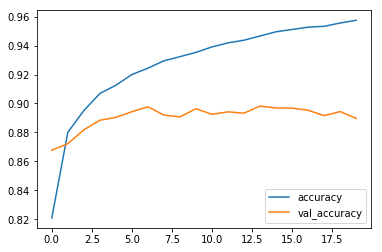

Currently on filter  3, layer 2, node 1000
Fold 1/3, params filters = 3, layers = 2, nodes = 1000
Fold 2/3, params filters = 3, layers = 2, nodes = 1000
Fold 3/3, params filters = 3, layers = 2, nodes = 1000
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 56)        14168     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 56)         0         
 2D)                                                             
                                              

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.4484 - accuracy: 0.8945 - 410ms/epoch - 1ms/step
Mean CV score + stddev: 0.9037833412488302 +/- 0.0043877978464672805
Accuracy on test set: 0.8945000171661377


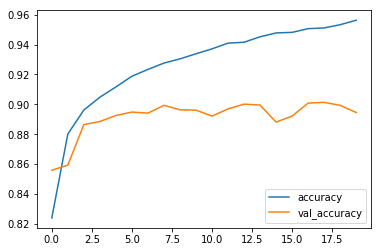

In [14]:
# Function to create model, required for KerasClassifier
def create_cnn_model( num_filters_layers=1, num_filters=28, num_hidden_layers=0, num_hidden_nodes=0, 
                     dropout=0, activation='relu' , optimizer='adam', summ=False):
    backend.clear_session()
    model = models.Sequential() # Create the model
    
    model.add(layers.Conv2D(num_filters, (3, 3), activation='relu', input_shape=(28, 28 , 1))) # add the first layer to convole the input matrix using a 3x3 kernal with a relu activation to prevent linearity
    model.add(layers.MaxPooling2D(pool_size = (2, 2))) #pool to decrease dimension of image
    
    for i in range(1, num_filters_layers):
        model.add(layers.Conv2D(num_filters*(2**i), (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D(pool_size = (2, 2))) #pool
    
    model.add(layers.Flatten())   
    
    for i in range(num_hidden_layers):
        tf.keras.layers.Dropout(dropout)    
        model.add(layers.Dense(num_hidden_nodes, activation=activation))

    model.add(layers.Dense(10))
    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    if summ:
        model.summary()
    return model

nFilters = [1,2,3]
hLayers = [0, 1, 2]
hNodes = [100, 250, 500, 1000]
histories = []
num_folds = 3
num_epochs= 20

cv_results = {}
cv_results['param_layers'] = []
cv_results['param_nodes'] = []
cv_results['param_filters'] = []
cv_results['mean_test_score'] = []
cv_results['std_test_score'] = []
cv_results['test_score'] = []
for i in range(num_folds):
    cv_results[f'split{i}_test_score'] = []

for filt in nFilters:
    for layer in hLayers:
        for node in hNodes:
            print(f'Currently on filter  {filt}, layer {layer}, node {node}')
            i = 0
            kfold = KFold(num_folds, shuffle=True, random_state=1)
            accs = []
            cv_results['param_filters'].append(filt)
            cv_results['param_layers'].append(layer)
            cv_results['param_nodes'].append(node)
            for train_ix, test_ix in kfold.split(img_train):
                print(f'Fold {i+1}/{num_folds}, params filters = {filt}, layers = {layer}, nodes = {node}')
                model = create_cnn_model(filt, 28, layer, node)
                trainX, trainY = img_train[train_ix], label_train[train_ix]
                testX, testY = img_train[test_ix], label_train[test_ix]
                history = model.fit(trainX, trainY, epochs=num_epochs, 
                            validation_data=(testX, testY), verbose=0)
                test_loss, test_acc = model.evaluate(testX,  testY, verbose=0)

                cv_results[f'split{i}_test_score'].append(test_acc)
                accs.append(test_acc)
                i += 1
                del model
            cv_results['mean_test_score'].append(np.mean(accs))
            cv_results['std_test_score'].append(np.std(accs))
            model = create_cnn_model(filt, 28, layer, node, summ=True)
            history = model.fit(img_train, label_train, epochs=num_epochs, 
                            validation_data=(img_test, label_test), verbose=0, callbacks=[TqdmCallback(verbose=1)])
            test_loss, test_acc = model.evaluate(img_test, label_test, verbose=2)
            print(f'Mean CV score + stddev: {np.mean(accs)} +/- {np.std(accs)}')
            print(f'Accuracy on test set: {test_acc}')
            cv_results['test_score'].append(test_acc)
            
            plt.plot(history.history['accuracy'], label='accuracy')
            plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
            plt.legend(loc="lower right")
            plt.show()
            histories.append(history)
            del model
            results_df = pd.DataFrame.from_dict(cv_results)
            results_df.to_csv("cnn.csv")
            if layer == 0:
                break
        


In [15]:
print(cv_results)
results_df = pd.DataFrame.from_dict(cv_results)
print(results_df)
results_df.to_pickle("cnn.pkl")

{'param_layers': [0, 1, 1, 1, 1, 2, 2, 2, 2, 0, 1, 1, 1, 1, 2, 2, 2, 2, 0, 1, 1, 1, 1, 2, 2, 2, 2], 'param_nodes': [100, 100, 250, 500, 1000, 100, 250, 500, 1000, 100, 100, 250, 500, 1000, 100, 250, 500, 1000, 100, 100, 250, 500, 1000, 100, 250, 500, 1000], 'param_filters': [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3], 'mean_test_score': [0.9091833432515463, 0.9214333295822144, 0.924999992052714, 0.9305750131607056, 0.9318333268165588, 0.9240833520889282, 0.9261916677157084, 0.9291999936103821, 0.9289249976476034, 0.9113666613896688, 0.9192249774932861, 0.9251833359400431, 0.9263333280881246, 0.925391674041748, 0.9214583436648051, 0.9246833324432373, 0.9233000079790751, 0.924791673819224, 0.9014250040054321, 0.9028166731198629, 0.9053000013033549, 0.9020833174387614, 0.9038083155949911, 0.9036083420117696, 0.9012083212534586, 0.9041166504224142, 0.9037833412488302], 'std_test_score': [7.72736973693887e-05, 0.003741468217346663, 0.0034507735919781382

In [16]:
%%script false --no-raise-error
# Function to create model, required for KerasClassifier
def create_model( activation='relu' , optimizer='adam'):
    backend.clear_session()
    model = models.Sequential() # Create the model
    model.add(layers.Conv2D(28, (3, 3), activation='relu', input_shape=(28, 28 , 1))) # add the first layer to convole the input matrix using a 3x3 kernal with a relu activation to prevent linearity
    model.add(layers.MaxPooling2D(pool_size = (2, 2))) #pool to decrease dimension of image
    model.add(layers.Conv2D(56, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size = (2, 2))) #pool
    model.add(layers.Conv2D(112, (3, 3), activation='relu'))


    model.add(layers.Flatten())
    model.add(layers.Dense(112, activation=activation))
    model.add(layers.Dense(10))
    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    #model.summary()
    return model

model = KerasClassifier(model=create_model, activation='relu' , optimizer='adam' ,verbose=0)
# define the grid search parameters
#activation = ['relu', 'tanh', 'sigmoid']
optimizer = ['SGD', 'Adagrad',  'Adam']
#convnet are sensitive to batch_size and epochs so do grid search on those too
#batch_size = [5, 10, 15] #cant try more due to limited ram
#epochs = [10, 20, 30]
#param_grid = dict( activation=activation, optimizer=optimizer , epochs=epochs)
param_grid = dict( optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=5, verbose=10)
print(grid)

grid_result = grid.fit(img_train, label_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [17]:
%%script false --no-raise-error
print(grid.best_params_)
print(grid.best_index_)
print(grid.best_score_)
results_df = pd.DataFrame.from_dict(grid.cv_results_)
print(results_df)
results_df.to_pickle("cnn.pkl")